In [169]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle
%matplotlib inline

def threshold_image(img):
  # RGB color thresholding
  rgb_low = np.array([200, 200, 10])
  rgb_high = np.array([255]*3)
  rgb_binary = cv2.inRange(img, rgb_low, rgb_high).astype(np.bool)
  
  # S channel thresholding
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  s_channel = hls[:,:, 2]
  s_channel_binary = np.zeros_like(s_channel)
  s_channel_binary[(s_channel >= 150) & (s_channel <= 200)] = 1
  s_channel_binary = s_channel_binary.astype(np.bool)
  
  # Gradient thresholding
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gradient_binary = gradient_threshold(gray)
  
  combined_color = np.zeros_like(img)
  combined_color[rgb_binary, 0] = 255
  combined_color[s_channel_binary, 1] = 255
  combined_color[gradient_binary, 2] = 255

  combined_binary = np.zeros_like(gray)
  combined_binary[rgb_binary | s_channel_binary | gradient_binary] = 255
  return combined_color, combined_binary


def gradient_threshold(gray):
  kernel_size = 5
  blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
  sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
  sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
  sobel_xy = np.sqrt(sobel_x**2 + sobel_y**2)
  sobel_xy *= 255.0 / np.max(sobel_xy)
  sobel_x *= 255.0 / np.max(sobel_x)
  binary = np.zeros_like(gray)
  binary[(sobel_xy >= 40) & (sobel_xy < 100)] = 1
  return binary.astype(np.bool)

def edge_threshold(gray):
  kernel_size = 5
  blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
  binary = cv2.Canny(blur_gray, 50, 100).astype(np.bool)
  return binary
  
def get_perspective_transform(w=1280, h=720):
  """Get perspective transform matrices."""
  src = np.float32([[590, 458], [700, 458], [1156, 714], [267, 714]])
  dst = np.float32([[w*0.25, h*0.2], [w*0.75, h*0.2], [w*0.75, h*0.99], [w*0.25, h*0.99]])
  M = cv2.getPerspectiveTransform(src, dst)
  Minv = cv2.getPerspectiveTransform(dst, src)
  return M, Minv


class Pipeline(object):
  def __init__(self, pickle_fname="camera_calibration.p"):
    cam_cal = pickle.load(open(pickle_fname, "rb"))
    self.mtx = cam_cal["mtx"]
    self.dist = cam_cal["dist"]
    self.M, self.Minv = get_perspective_transform()
    
  def process(self, img):
    undistorted = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    h, w = img.shape[0], img.shape[1]
    threshold_color, threshold_binary = threshold_image(undistorted)
    warped = cv2.warpPerspective(undistorted, self.M, (w, h), flags=cv2.INTER_LINEAR)
    warped_color = cv2.warpPerspective(threshold_color, self.M, (w, h), flags=cv2.INTER_LINEAR)
    return threshold_color, warped, warped_color


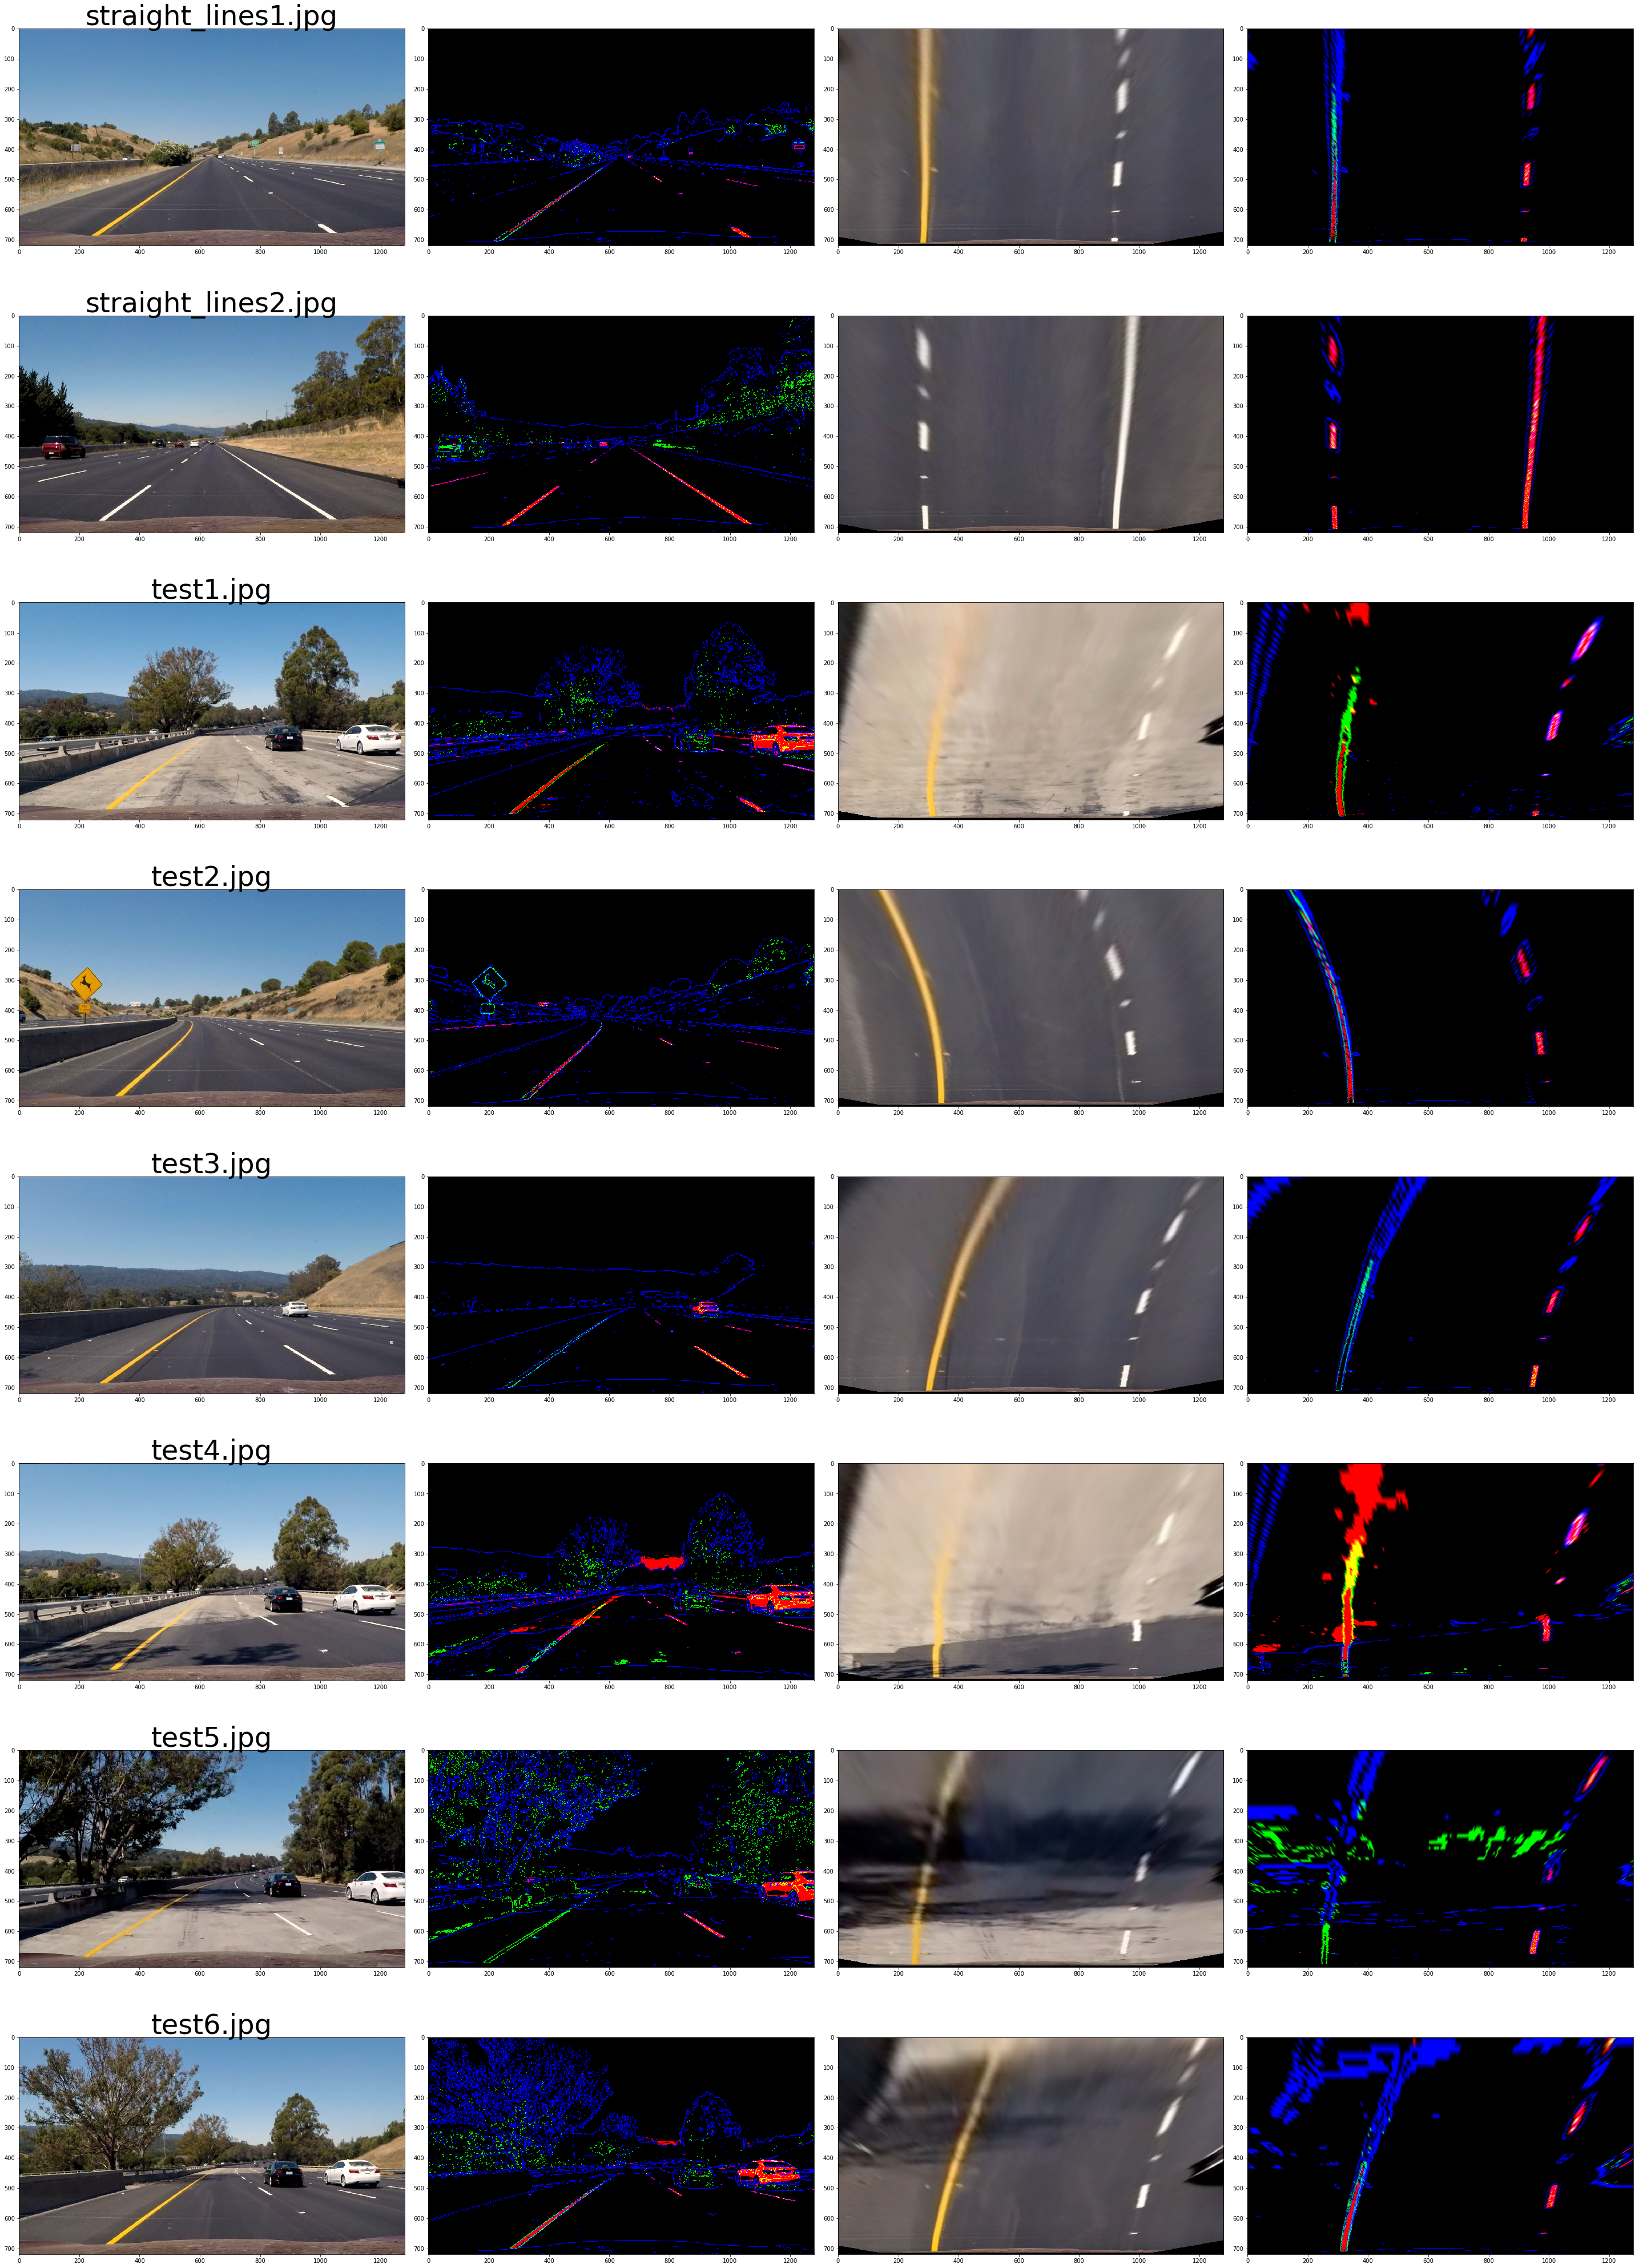

In [170]:
images = glob.glob("test_images/*.jpg")
images.sort()
fig, axes = plt.subplots(len(images), 4, figsize=(10*4, 7*len(images)))
fig.tight_layout()
pipeline = Pipeline()
for i, fname in enumerate(images):
  img = cv2.imread(fname)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  combined_color, combined_binary = threshold_image(img)
  threshold_color, warped, warped_color = pipeline.process(img)
  base_name = os.path.basename(fname)
  #cv2.imwrite("output_images/" + base_name, combined_binary)
  for j, myimg in enumerate([img, threshold_color, warped, warped_color]):
    if len(myimg.shape) == 3:
      axes[i, j].imshow(myimg)
    else:
      axes[i, j].imshow(myimg, cmap='gray')
    axes[i, 0].set_title(base_name, fontsize=48)
